# MUSCIMA++ Tutorial

This is a tutorial for using the `muscima` package to work with the MUSCIMA++
dataset.

We assume you have already gone through the README and downloaded the dataset. Let's load it.

In [1]:
import os
from muscima.io import parse_cropobject_list

# Change this to reflect wherever your MUSCIMA++ data lives
CROPOBJECT_DIR = os.path.join(os.environ['HOME'], 'data/MUSCIMA++/v0.9/data/cropobjects')

cropobject_fnames = [os.path.join(CROPOBJECT_DIR, f) for f in os.listdir(CROPOBJECT_DIR)]
docs = [parse_cropobject_list(f) for f in cropobject_fnames]

Let's do something straightforward: symbol classification.

## Symbol Classification

Let's try to tell apart quarter notes from half notes.

However, notes are recorded as individual primitives in MUSCIMA++,
so we need to extract notehead-stem pairs from the data
using their relationships.
Quarter notes are all `full-notehead`-`stem` pairs with no beam or flag.
Half-notes are all `empty-notehead`-`stem` pairs.

After we extract the note classes, we will need to compute features for classification.
To do that, we first need to "draw" the symbols in the appropriate relative positions.
Then, we can extract whatever features we need.

Finally, we train a classifier and evaluate it.


### Extracting notes

In [4]:
# Bear in mind that the outlinks are integers, only valid within the same document.
# Therefore, we define a function per-document, not per-dataset.

def extract_notes_from_doc(cropobjects):
    """Finds all ``(full-notehead, stem)`` pairs that form
    quarter or half notes. Returns two lists of CropObject tuples:
    one for quarter notes, one of half notes.
    
    :returns: quarter_notes, half_notes
    """
    _cropobj_dict = {c.objid: c for c in cropobjects}
    
    notes = []
    for c in cropobjects:
        if (c.clsname == 'notehead-full') or (c.clsname == 'notehead-empty'):
            _has_stem = False
            _has_beam_or_flag = False            
            stem_obj = None
            for o in c.outlinks:
                _o_obj = _cropobj_dict[o]
                if _o_obj.clsname == 'stem':
                    _has_stem = True
                    stem_obj = _o_obj
                elif _o_obj.clsname == 'beam':
                    _has_beam_or_flag = True
                elif _o_obj.clsname.endswith('flag'):
                    _has_beam_or_flag = True
            if _has_stem and (not _has_beam_or_flag):
                # We also need to check against quarter-note chords.
                # Stems only have inlinks from noteheads, so checking
                # for multiple inlinks will do the trick.
                if len(stem_obj.inlinks) == 1:
                    notes.append((c, stem_obj))
    
    quarter_notes = [(n, s) for n, s in notes if n.clsname == 'notehead-full']
    half_notes = [(n, s) for n, s in notes if n.clsname == 'notehead-empty']
    return quarter_notes, half_notes

qns_and_hns = [extract_notes_from_doc(cropobjects) for cropobjects in docs]

Now, we don't need the `objid` anymore, so we can lump the notes from all 140 documents together.

In [5]:
import itertools
qns = list(itertools.chain(*[qn for qn, hn in qns_and_hns]))
hns = list(itertools.chain(*[hn for qn, hn in qns_and_hns]))

len(qns), len(hns)

(4320, 1181)

It seems that we have some 4320 isolated quarter notes and 1181 isolated half-notes in our data.
Let's create their images now.

### Creating note images

Each notehead and stem CropObject has its own mask and its bounding box coordinates. We need to combine these two things, in order to create a binary image of the note.

In [6]:
import numpy

def get_image(cropobjects, margin=1):
    """Paste the cropobjects' mask onto a shared canvas.
    There will be a given margin of background on the edges."""
    
    # Get the bounding box into which all the objects fit
    top = min([c.top for c in cropobjects])
    left = min([c.left for c in cropobjects])
    bottom = max([c.bottom for c in cropobjects])
    right = max([c.right for c in cropobjects])
    
    # Create the canvas onto which the masks will be pasted
    height = bottom - top + 2 * margin
    width = right - left + 2 * margin
    canvas = numpy.zeros((height, width), dtype='uint8')
    
    for c in cropobjects:
        # Get coordinates of upper left corner of the CropObject
        # relative to the canvas
        _pt = c.top - top + margin
        _pl = c.left - left + margin
        # We have to add the mask, so as not to overwrite
        # previous nonzeros when symbol bounding boxes overlap.
        canvas[_pt:_pt+c.height, _pl:_pl+c.width] += c.mask
        
    canvas[canvas > 0] = 1
    return canvas

qn_images = [get_image(qn) for qn in qns]
hn_images = [get_image(hn) for hn in hns]

Let's visualize some of these notes, to check whether everything worked.
(For this, we assume you have matplotlib. If not, you can skip this step.)

In [7]:
import matplotlib.pyplot as plt

def show_mask(mask):
    plt.imshow(mask, cmap='gray', interpolation='nearest')
    plt.show()

def show_masks(masks, row_length=5):
    n_masks = len(masks)
    n_rows = n_masks // row_length + 1
    n_cols = min(n_masks, row_length)
    fig = plt.figure()
    for i, mask in enumerate(masks):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(mask, cmap='gray', interpolation='nearest')
    # Let's remove the axis labels, they clutter the image.
    for ax in fig.axes:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_xticks([])
    plt.show()

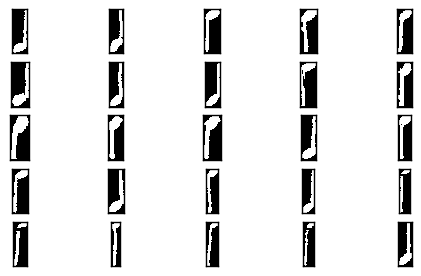

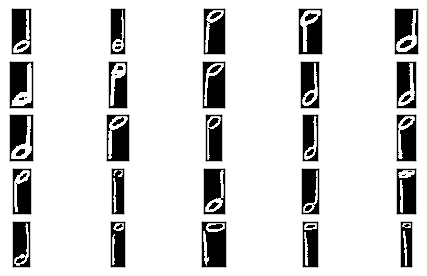

In [8]:
show_masks(qn_images[:25])
show_masks(hn_images[:25])

It seems that the extraction went all right.

### Feature Extraction

Now, we need to somehow turn the note images into classifier inputs.

Let's get some inspiration from the setup of the HOMUS dataset. 
In their baseline classification experiments, the authors just resized their images
to 20x20. For notes, however, this may not be such a good idea, because
it will make them too short. Let's instead resize to 40x10.

In [9]:
from skimage.transform import resize

qn_resized = [resize(qn, (40, 10)) for qn in qn_images]
hn_resized = [resize(hn, (40, 10)) for hn in hn_images]

# And re-binarize, to compensate for interpolation effects
for qn in qn_resized:
    qn[qn > 0] = 1
for hn in hn_resized:
    hn[hn > 0] = 1

How do the resized notes look?

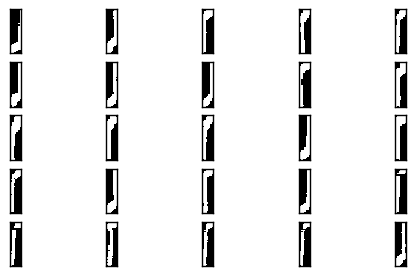

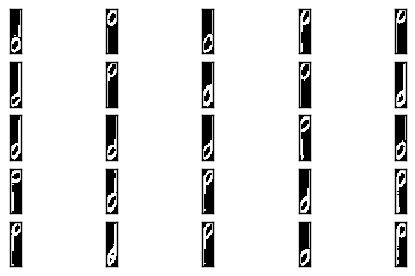

In [10]:
show_masks(qn_resized[:25])
show_masks(hn_resized[-25:])

### Classification

We now need to add the output labels and make a train-dev-test split out of this.

Let's make a balanced dataset, to keep things simpler.

In [11]:
# Randomly pick an equal number of quarter-notes.
n_hn = len(hn_resized)
import random
random.shuffle(qn_resized)
qn_selected = qn_resized[:n_hn]

Now, create the output labels and merge the data into one dataset.

In [25]:
Q_LABEL = 1
H_LABEL = 0

qn_labels = [Q_LABEL for _ in qn_selected]
hn_labels = [H_LABEL for _ in hn_resized]



notes = qn_selected + hn_resized
# Flatten data
notes_flattened = [n.flatten() for n in notes]
labels = qn_labels + hn_labels

Let's use the `sklearn` package for experimental setup.
Normally, we would do cross-validation on data of this small size,
but for the purposes of the tutorial, we will stick to just one train/test split.

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    notes_flattened, labels, test_size=0.25, random_state=42,
    stratify=labels)

What could we use to classify this data? Perhaps a k-NN classifier might work.

In [43]:
from sklearn.neighbors import KNeighborsClassifier

K=5

# Trying the defaults first.
clf = KNeighborsClassifier(n_neighbors=K)
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Let's run the classifier now and evaluate the results.

In [44]:
y_test_pred = clf.predict(X_test)

In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred, target_names=['half', 'quarter']))

             precision    recall  f1-score   support

       half       0.98      0.87      0.92       296
    quarter       0.88      0.98      0.93       295

avg / total       0.93      0.93      0.93       591



#### NOT BAD.



Apparently, most mistakes happen when half-notes are classified as quarter-notes.
Also, remember that we made the train/test split randomly, so there are almost certainly
notes from each writer both in the test set and in the training data. This is
ripe picking for the kNN classifier.

Can we perhaps quantify that effect?

...and that is beyond the scope of this tutorial.